# Import libraries

In [36]:
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import importlib.util
import sys

In [3]:
from scripts.parse_vars import parse_variables

In [4]:
path_vars = f"../../geno_simulation.txt"
R_directory = f"../../rstudio_geno_simulation"
R_file = f"create_geno.R"

variables = parse_variables(path_vars)
if 'G' not in globals():
    G = int(variables['G'])
if 'L' not in globals():
    L = int(variables['L'])
if 'c' not in globals():
    c = int(variables['c'])
if 'k' not in globals():
    k = int(variables['k'])
if 'M' not in globals():
    M = float(variables['M'])
if 'HWE' not in globals():
    HWE = int(variables['HWE'])

if 'tools' not in globals():
    tools = ['PCA', 'abyss_counted', 'abyss', 'no_corr']


if 'scenarios' not in globals():
    scenarios = ['snp_effect',
                 'linear_continuous',
                 'non_linear_continuous',
                 'discrete_global',
                 'discrete_localized',
                 'mix_linear_continuous',
                 'mix_non_linear_continuous',
                 'mix_discrete_global',
                 'mix_discrete_localized']

if 'very_rare_threshold_L' not in globals():
    very_rare_threshold_L = float(variables['very_rare_threshold_L'])
if 'very_rare_threshold_H' not in globals():
    very_rare_threshold_H = float(variables['very_rare_threshold_H'])
if 'rare_threshold_L' not in globals():
    rare_threshold_L = float(variables['rare_threshold_L'])
if 'rare_threshold_H' not in globals():
    rare_threshold_H = float(variables['rare_threshold_H'])
if 'common_threshold_L' not in globals():
    common_threshold_L = float(variables['common_threshold_L'])
if 'common_threshold_H' not in globals():
    common_threshold_H = float(variables['common_threshold_H'])
if 'F' not in globals():
    F = float(variables['F'])
commands = [
    f"G <- {G}",
    f"L <- {L}",
    f"c <- {c}",
    f"k <- {k}",
    f"M <- {M}",
    f'setwd("{R_directory}")',
    f'source("{R_file}", echo=TRUE)'
]


# Concatenate commands into a single string
r_script = ";".join(commands)

# Run the R script
result = subprocess.run(['Rscript', '-e', r_script], capture_output=True, text=True)


In [5]:
path_geno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/genotype"
geno = pd.read_pickle((f"{path_geno}/complete_inbred.pkl"))

In [6]:
geno

,C_1_MAF_0.500,C_2_MAF_0.500,C_3_MAF_0.500,C_4_MAF_0.500,C_5_MAF_0.500,C_6_MAF_0.500,C_7_MAF_0.499,C_8_MAF_0.499,C_9_MAF_0.499,C_10_MAF_0.499,...,VR_3991_MAF_0.045,VR_3992_MAF_0.044,VR_3993_MAF_0.044,VR_3994_MAF_0.044,VR_3995_MAF_0.044,VR_3996_MAF_0.043,VR_3997_MAF_0.043,VR_3998_MAF_0.042,VR_3999_MAF_0.042,VR_4000_MAF_0.042
0,1,1,-1,1,-1,-1,1,1,-1,-1,...,1,1,1,1,1,1,0,1,1,1
1,1,1,-1,1,0,0,1,1,-1,-1,...,1,1,1,1,1,1,1,1,0,1
2,1,1,-1,1,-1,-1,1,1,-1,0,...,1,1,1,1,1,1,1,1,1,1
3,1,1,-1,1,-1,-1,1,1,0,-1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,0,1,-1,-1,1,1,-1,-1,...,1,1,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1,1,1,0,1,-1,-1,1,0,0,...,1,1,1,1,0,1,1,1,1,1
1996,-1,1,1,-1,1,-1,-1,1,1,-1,...,1,1,1,0,1,1,1,1,1,1
1997,-1,1,1,-1,1,1,-1,1,1,-1,...,1,1,1,0,1,1,1,1,1,1
1998,-1,0,1,-1,1,-1,-1,1,1,-1,...,1,1,0,1,0,1,1,1,1,0


In [7]:
path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/phenotype/"
pheno = pd.read_pickle(f"{path_pheno}/env_pheno.pkl")
humans = pd.read_pickle(f"{path_pheno}/inbred_humans.pkl")

# PCA

In [8]:
from sklearn.preprocessing import StandardScaler

# Standardize each SNP (column): zero mean, unit variance
scaler = StandardScaler()
X_std = scaler.fit_transform(geno.values)

In [9]:
from sklearn.decomposition import PCA

# Run PCA and extract, say, top 10 components
pca = PCA(n_components=10)
pcs = pca.fit_transform(X_std)

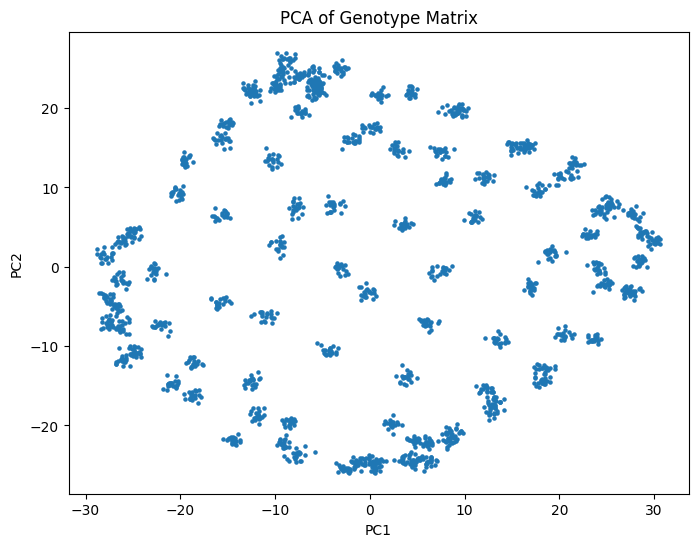

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(pcs[:, 0], pcs[:, 1], s=5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Genotype Matrix")
plt.show()


In [12]:
print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.06586123 0.05960183 0.03216571 0.02371215 0.02127445 0.01729588
 0.0162435  0.01266334 0.0119868  0.01171513]


# Gwas

In [15]:
env_factor = "01_pheno_linear"

In [16]:
from statsmodels.api import OLS, add_constant
import numpy as np
import pandas as pd

# Extract phenotype
y = pheno[env_factor].values

# Assume 'pcs' is a NumPy array or DataFrame with shape (n_samples, n_pcs)
# If it's a NumPy array, convert to DataFrame
pcs_df = pd.DataFrame(pcs, columns=[f'PC{i+1}' for i in range(pcs.shape[1])])

# Initialize results list
results = []

# Loop through SNPs
for snp in geno.columns:
    x = geno[snp].values
    # Combine SNP with PCs
    X = pd.concat([pd.Series(x, name='SNP'), pcs_df], axis=1)
    X = add_constant(X)  # Add intercept
    model = OLS(y, X).fit()
    pval = model.pvalues['SNP']  # p-value for SNP term
    logp = -np.log10(pval)
    results.append((snp, logp))

# Create and sort results DataFrame
gwas_results = pd.DataFrame(results, columns=['SNP', '-log10(p)'])
gwas_results = gwas_results.sort_values('-log10(p)', ascending=False).reset_index(drop=True)

# Display
gwas_results


,SNP,-log10(p)
0,C_1056_MAF_0.225,61.884472
1,C_1117_MAF_0.218,59.380651
2,C_1099_MAF_0.219,55.279163
3,C_1110_MAF_0.218,54.409860
4,C_161_MAF_0.462,53.745995
...,...,...
3995,R_3538_MAF_0.055,0.001175
3996,R_3531_MAF_0.055,0.000791
3997,R_1649_MAF_0.152,0.000664
3998,R_3188_MAF_0.061,0.000135


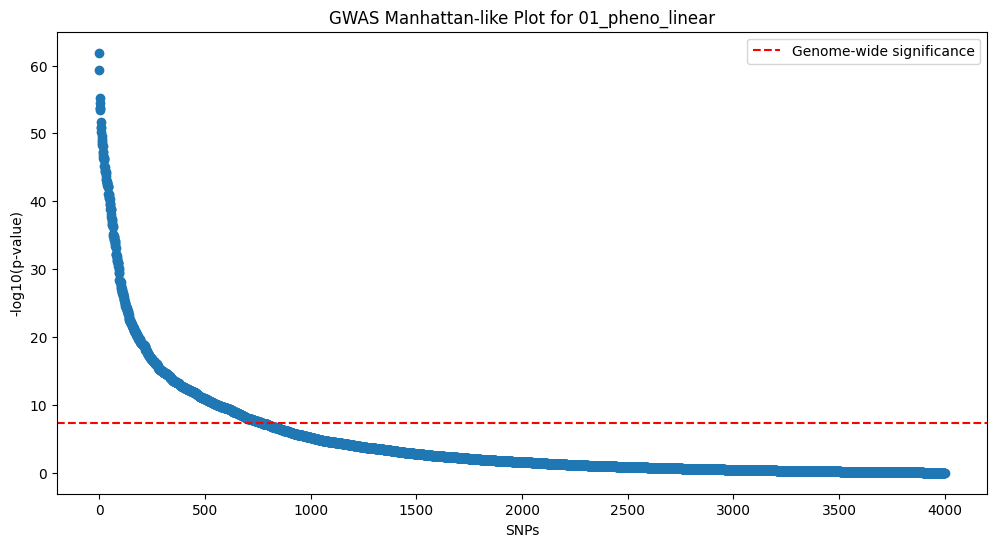

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(gwas_results['-log10(p)'].values, marker='o', linestyle='none')
plt.axhline(-np.log10(5e-8), color='red', linestyle='--', label='Genome-wide significance')
plt.xlabel('SNPs')
plt.ylabel('-log10(p-value)')
plt.title(f'GWAS Manhattan-like Plot for {env_factor}')
plt.legend()
plt.show()

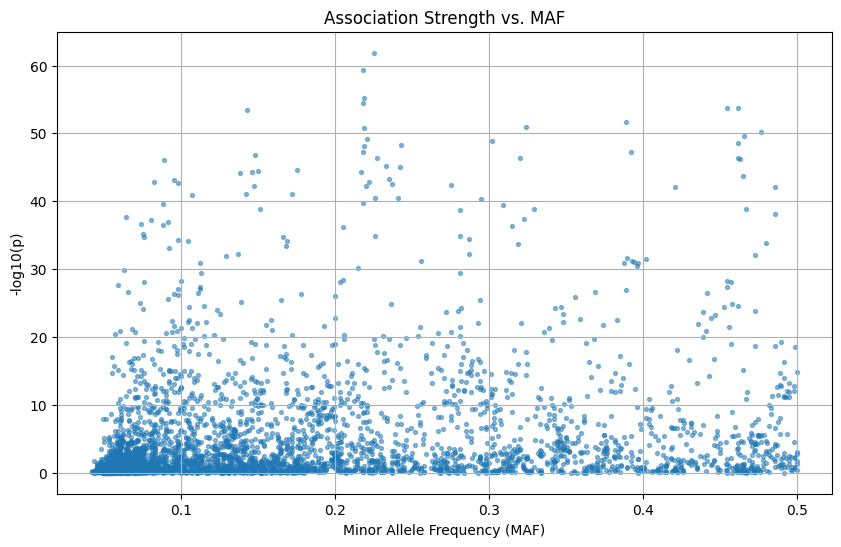

In [18]:


# Extract MAF from SNP names
gwas_results['MAF'] = gwas_results['SNP'].str.extract(r'MAF_([\d.]+)').astype(float)

# Plot MAF vs -log10(p)
plt.figure(figsize=(10, 6))
plt.scatter(gwas_results['MAF'], gwas_results['-log10(p)'], alpha=0.5, s=8)
plt.xlabel("Minor Allele Frequency (MAF)")
plt.ylabel("-log10(p)")
plt.title("Association Strength vs. MAF")
plt.grid(True)
plt.show()


# Showing where it goes wrong

In [19]:
geno

,C_1_MAF_0.500,C_2_MAF_0.500,C_3_MAF_0.500,C_4_MAF_0.500,C_5_MAF_0.500,C_6_MAF_0.500,C_7_MAF_0.499,C_8_MAF_0.499,C_9_MAF_0.499,C_10_MAF_0.499,...,VR_3991_MAF_0.045,VR_3992_MAF_0.044,VR_3993_MAF_0.044,VR_3994_MAF_0.044,VR_3995_MAF_0.044,VR_3996_MAF_0.043,VR_3997_MAF_0.043,VR_3998_MAF_0.042,VR_3999_MAF_0.042,VR_4000_MAF_0.042
0,1,1,-1,1,-1,-1,1,1,-1,-1,...,1,1,1,1,1,1,0,1,1,1
1,1,1,-1,1,0,0,1,1,-1,-1,...,1,1,1,1,1,1,1,1,0,1
2,1,1,-1,1,-1,-1,1,1,-1,0,...,1,1,1,1,1,1,1,1,1,1
3,1,1,-1,1,-1,-1,1,1,0,-1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,0,1,-1,-1,1,1,-1,-1,...,1,1,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1,1,1,0,1,-1,-1,1,0,0,...,1,1,1,1,0,1,1,1,1,1
1996,-1,1,1,-1,1,-1,-1,1,1,-1,...,1,1,1,0,1,1,1,1,1,1
1997,-1,1,1,-1,1,1,-1,1,1,-1,...,1,1,1,0,1,1,1,1,1,1
1998,-1,0,1,-1,1,-1,-1,1,1,-1,...,1,1,0,1,0,1,1,1,1,0


In [25]:
# Create the three new DataFrames
minor = (geno == -1).astype(int)
het = (geno == 0).astype(int)
major = (geno == 1).astype(int)


In [27]:
pcs

array([[-26.61179906,  -4.65190384, -19.69274024, ...,  -5.35400202,
          7.78157652,   2.73234198],
       [-27.22934105,  -5.29309677, -19.4141515 , ...,  -5.65264285,
          7.04224121,   5.2033561 ],
       [-26.56840024,  -4.88320426, -19.45573532, ...,  -4.63547193,
          7.23792392,   3.76776468],
       ...,
       [ 29.78761863,   3.36344651, -20.75216329, ...,  -4.6564927 ,
         13.43381833,  10.88307152],
       [ 29.96847114,   2.94899831, -21.43656821, ...,  -3.69187825,
         13.173547  ,  11.56568919],
       [ 29.70982199,   3.58487486, -22.13005394, ...,  -3.87735962,
         12.17083302,   9.13497095]])

In [66]:
nr_pcs = 1
pcs = pcs[:, :nr_pcs]


In [67]:
minor

,C_1_MAF_0.500,C_2_MAF_0.500,C_3_MAF_0.500,C_4_MAF_0.500,C_5_MAF_0.500,C_6_MAF_0.500,C_7_MAF_0.499,C_8_MAF_0.499,C_9_MAF_0.499,C_10_MAF_0.499,...,VR_3991_MAF_0.045,VR_3992_MAF_0.044,VR_3993_MAF_0.044,VR_3994_MAF_0.044,VR_3995_MAF_0.044,VR_3996_MAF_0.043,VR_3997_MAF_0.043,VR_3998_MAF_0.042,VR_3999_MAF_0.042,VR_4000_MAF_0.042
0,0,0,1,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,1,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1997,1,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1998,1,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


/home/mat2m10/.pyenv/versions/3.12.9/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step


/home/mat2m10/.pyenv/versions/3.12.9/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step


/home/mat2m10/.pyenv/versions/3.12.9/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step


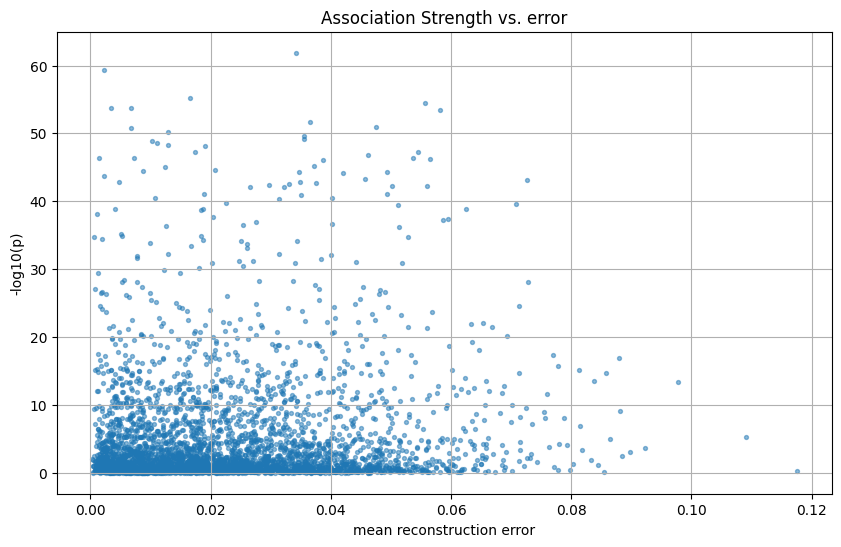

In [68]:
# Build model
model = Sequential([
    Dense(minor.shape[1], input_shape=(pcs.shape[1],), activation='linear')
])

model.compile(optimizer=Adam(1e-3), loss='mse')

# Train model
history = model.fit(pcs, minor, epochs=100, batch_size=32, verbose=0)

# Predict on the original PCs input
predicted_minor = model.predict(pcs)

model = Sequential([
    Dense(het.shape[1], input_shape=(pcs.shape[1],), activation='linear')
])

model.compile(optimizer=Adam(1e-3), loss='mse')

# Train model
history = model.fit(pcs, het, epochs=100, batch_size=32, verbose=0)
predicted_het = model.predict(pcs)

model = Sequential([
    Dense(major.shape[1], input_shape=(pcs.shape[1],), activation='linear')
])

model.compile(optimizer=Adam(1e-3), loss='mse')

# Train model
history = model.fit(pcs, major, epochs=100, batch_size=32, verbose=0)
predicted_major = model.predict(pcs)

error = abs(1 - (predicted_major + predicted_minor + predicted_het))
mean_error = np.mean(error, axis=0)

gwas_results["mean_reconstruction_error"] = mean_error

# Plot MAF vs -log10(p)
plt.figure(figsize=(10, 6))
plt.scatter(gwas_results['mean_reconstruction_error'], gwas_results['-log10(p)'], alpha=0.5, s=8)
plt.xlabel("mean reconstruction error")
plt.ylabel("-log10(p)")
plt.title("Association Strength vs. error")
plt.grid(True)
plt.show()


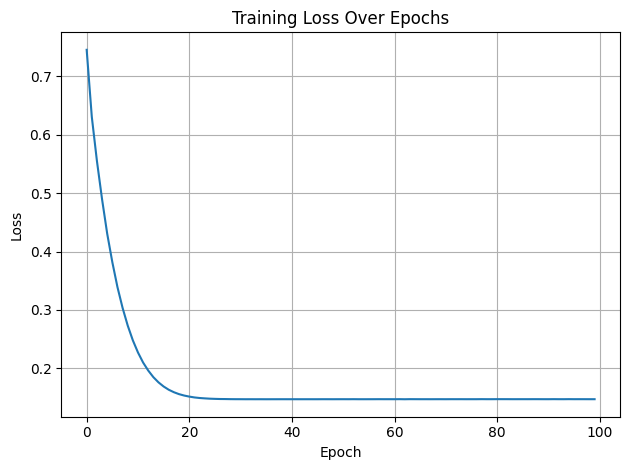

In [69]:
# Plot training loss
plt.plot(history.history['loss'])
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
len(mean_error)

4000

KeyError: 'SNP_ID'

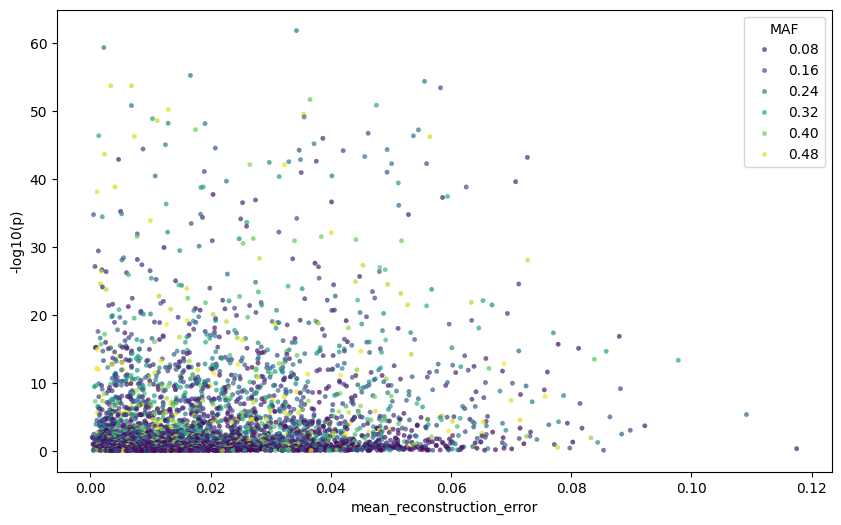

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume gwas_results has: ['mean_reconstruction_error', '-log10(p)', 'MAF', 'SNP_ID']

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=gwas_results,
    x="mean_reconstruction_error",
    y="-log10(p)",
    hue="MAF",
    palette="viridis",
    s=10,
    alpha=0.7,
    edgecolor=None
)

# Label top 10 most significant SNPs
top_outliers = gwas_results.nlargest(10, "-log10(p)")
for _, row in top_outliers.iterrows():
    plt.text(
        row["mean_reconstruction_error"],
        row["-log10(p)"],
        row["SNP_ID"],
        fontsize=8,
        ha='right',
        va='bottom'
    )

plt.xlabel("Mean Reconstruction Error")
plt.ylabel("-log10(p)")
plt.title("Association Strength vs. Reconstruction Error")
plt.grid(True)
plt.legend(title="MAF", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
